# BERT NUSWhispers

This notebook documents various explorations with regards to using BERT in the NUSWhispers sentiment analysis task.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/CindyTsai1/CS4248-Team23.git

Cloning into 'CS4248-Team23'...
remote: Enumerating objects: 440, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 440 (delta 7), reused 46 (delta 7), pack-reused 390
Receiving objects: 100% (440/440), 129.83 MiB | 28.49 MiB/s, done.
Resolving deltas: 100% (219/219), done.
Checking out files: 100% (136/136), done.


In [3]:
!pip install datasets transformers >/dev/null 2>&1

In [4]:
!pip install --upgrade --force-reinstall imbalanced-learn >/dev/null 2>&1

In [5]:
# check successful installation of transformers
!python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('we love you'))"

2021-04-21 07:13:06.059049: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Downloading: 100% 629/629 [00:00<00:00, 566kB/s]
Downloading: 100% 268M/268M [00:03<00:00, 73.4MB/s]
Downloading: 100% 232k/232k [00:00<00:00, 686kB/s]
Downloading: 100% 48.0/48.0 [00:00<00:00, 40.7kB/s]
[{'label': 'POSITIVE', 'score': 0.9998704791069031}]


In [6]:
from copy import deepcopy
import numpy as np
import pandas as pd
import transformers
import torch
import warnings
import torch.nn as nn
from torch.nn import GELU
from datasets import Dataset, load_metric
from transformers import BertModel, BertForSequenceClassification, BertForPreTraining,\
                         BertTokenizerFast, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from imblearn.metrics import macro_averaged_mean_absolute_error

warnings.filterwarnings('ignore')

In [7]:
model_name = 'bert-base-cased'
num_labels = 5

In [8]:
def pt_bert(model_name, num_labels, train_mode=True):
  model = BertForSequenceClassification.from_pretrained(model_name, 
                                                        num_labels=num_labels)
  if train_mode:
    model.train()
  return model

def pt_bert_extended(model_name, num_labels, train_mode=True):
  '''
  Use this model if you want to extend the BERT model with other 
  features, e.g. text length besides the embeddings.
  '''
  class ExtendedBert(nn.Module):
      def __init__(self):
          super().__init__()

          self.bert = BertModel.from_pretrained(model_name)
          self.linear = nn.Linear(768, 768)
          self.act = GELU()
          self.classifier = nn.Linear(768, num_labels)

      def forward(self, encoded, other_feats):
          # get the hidden state of the last layer
          last_hidden = self.bert(**encoded)[0]
          # concatenate with the other given features
          cat = torch.cat([last_hidden, other_feats], dim=-1)
          # pass through linear layer
          output = self.linear(cat)
          # pass through non-linear activation and final classifier layer
          return self.classifier(self.act(output))
  model = ExtendedBert()
  if train_mode:
    model.train()
  return model

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    mmae = macro_averaged_mean_absolute_error(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        # 'precision': precision,
        # 'recall': recall,
        'mmae': mmae,
    }

In [10]:
def load_nuswhispers_datasets(model_name, split=True):
  # load NUSWhispers dataset
  data_file = '/content/CS4248-Team23/data/v6_remove_punctuation_remove_non_english_correct_spelling_replace_short_form_slang.csv'
  # data_file = '/content/CS4248-Team23/data/v7_expand_contraction_remove_punctuation_remove_stopwords_remove_non_english_correct_spelling_replace_short_form_slang_lemmatization.csv'
  # data_file = '/content/CS4248-Team23/data/v7_expand_contraction.csv'
  # data_file = '/content/CS4248-Team23/data/v7_expand_contraction_remove_punctuation_remove_non_english_correct_spelling_replace_short_form_slang_lemmatization1.csv'

  old_train = pd.read_csv(data_file)
  old_train.dropna(subset=['text'], inplace=True)
  train = deepcopy(old_train)

  tokenizer = BertTokenizerFast.from_pretrained(model_name)
  
  def preprocess_function(examples):
      return tokenizer(examples['text'], truncation=True, padding=True)

  if split:
    train_dataset, test_dataset = train_test_split(train, test_size=0.2, random_state=10)
    train_dataset, val_dataset = train_test_split(train, test_size=0.2, random_state=10)
    test_dataset, val_dataset = train_test_split(val_dataset, test_size=0.5, random_state=10)

    train_dataset_text = deepcopy(train_dataset[['text','label']])
    val_dataset_text = deepcopy(val_dataset[['text','label']])
    test_dataset_text = deepcopy(test_dataset[['text','label']])

    train_dataset = Dataset.from_pandas(train_dataset_text)
    val_dataset = Dataset.from_pandas(val_dataset_text)
    test_dataset = Dataset.from_pandas(test_dataset_text)

    train_dataset = train_dataset.map(preprocess_function, batched=True, load_from_cache_file=False)
    val_dataset = val_dataset.map(preprocess_function, batched=True, load_from_cache_file=False)
    test_dataset = test_dataset.map(preprocess_function, batched=True, load_from_cache_file=False)

    columns_to_return = ['input_ids', 'label', 'attention_mask']
    train_dataset.set_format(type='torch', columns=columns_to_return)
    val_dataset.set_format(type='torch', columns=columns_to_return)
    test_dataset.set_format(type='torch', columns=columns_to_return)
    return train_dataset, val_dataset, test_dataset
  else:
    train_dataset_text = deepcopy(train[['text','label']])
    train_dataset = Dataset.from_pandas(train_dataset_text)
    print(train_dataset_text)
    train_dataset = train_dataset.map(preprocess_function, batched=True, load_from_cache_file=False)
    columns_to_return = ['input_ids', 'label', 'attention_mask']
    train_dataset.set_format(type='torch', columns=columns_to_return)
    return train_dataset

In [11]:
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [12]:
ds = load_nuswhispers_datasets(model_name, False)

                                                   text  label
0                                                     D      0
1                                    Im sorry SpongeBob      0
2     Dont chase after who you like If you are meant...      0
3     Friends shouldnt expect anything in return Thi...      2
4     I will stop procrastinating and catch up with ...      0
...                                                 ...    ...
4402  You Yay phase 2 but Im just going to stay at h...      0
4403  Young and inexperienced person asking for some...      0
4404                                   Zoning meanwhile      0
4405                                               Po        0
4406                                                         0

[4407 rows x 2 columns]


# 1. Extracting Contextual Embeddings of Pre-Trained BERT

As we also have other non-textual features, we could extract the contextual embeddings of the NUSWhispers posts from the pre-trained BERT model. 

These embeddings (of size 768) can then be combined with the other features and fed into another classification model, e.g. Logistic Regression or a simple neural network (this is done in our repository's [main.py](https://github.com/CindyTsai1/CS4248-Team23/blob/main/main.py))

In [ ]:
# Load pretrained model/tokenizer
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, 
                                                    transformers.BertTokenizer, 
                                                    'bert-base-cased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
data_file = '/content/CS4248-Team23/data/v6_remove_punctuation_remove_non_english_correct_spelling_replace_short_form_slang.csv'
df = pd.read_csv(data_file)

def generate_embedding(x):
  encoding = tokenizer.encode(x, truncation=True, padding=True, max_length=512)
  input_ids = torch.tensor(encoding).unsqueeze(0)
  with torch.no_grad():
    output = model(input_ids)
    last_hidden_state = output[0]
  # Get [CLS] embedding
  features = last_hidden_state[:,0,:].numpy()
  return features

embeddings = df['text'].apply(generate_embedding)

In [ ]:
embeddings.to_csv('drive/MyDrive/pt_bert_embeddings.csv')

# 2. Finetuning BERT on NUSWhispers Sentiment Analysis Task

In the previous section, the pre-trained BERT model was simply used to evaluate and extract the embeddings from the NUSWhispers posts.

In this section, we fine-tune the pre-trained BERT on the NUSWhispers post specifically for our text classification (sentiment analysis) task.

References:
- https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

In [ ]:
train_dataset, val_dataset, test_dataset = load_nuswhispers_datasets(model_name)

In [ ]:
model = pt_bert(model_name, num_labels, True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
training_args = TrainingArguments(
    output_dir='./nuswhispersbert/results',          # output directory
    learning_rate=2e-5,
    num_train_epochs=4.0,            # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_ratio=0.1,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./nuswhispersbert/logs',            # directory for storing logs
    load_best_model_at_end=True,
    metric_for_best_model='mmae',
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss
500,1.306900


TrainOutput(global_step=884, training_loss=1.161138336043552, metrics={'train_runtime': 883.7104, 'train_samples_per_second': 1.0, 'total_flos': 4690316676808704.0, 'epoch': 4.0, 'init_mem_cpu_alloc_delta': 1601875968, 'init_mem_gpu_alloc_delta': 433785344, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 14680064, 'train_mem_gpu_alloc_delta': 1306636800, 'train_mem_cpu_peaked_delta': 102400, 'train_mem_gpu_peaked_delta': 12996723712})

In [ ]:
# save model
save_directory = '/content/drive/MyDrive/BERT/nuswhispers_bert_4/'
tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)

## Evaluating Model

In [ ]:
save_directory = '/content/drive/MyDrive/BERT/nuswhispers_bert_4/'
tokenizer = BertTokenizerFast.from_pretrained(save_directory)
model = BertForSequenceClassification.from_pretrained(save_directory)

In [ ]:
training_args = TrainingArguments(
    output_dir='./nuswhispersbert/results',          # output directory
    learning_rate=2e-5,
    num_train_epochs=4.0,            # total # of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_ratio=0.1,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./nuswhispersbert/logs',            # directory for storing logs
    load_best_model_at_end=True,
    metric_for_best_model='mmae',
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.evaluate()

{'eval_accuracy': 0.5328798185941043,
 'eval_f1': 0.38885340388514666,
 'eval_loss': 1.2009128332138062,
 'eval_mem_cpu_alloc_delta': 212992,
 'eval_mem_cpu_peaked_delta': 57344,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 1158102016,
 'eval_mmae': 0.9938569424333561,
 'eval_runtime': 7.6935,
 'eval_samples_per_second': 57.321,
 'init_mem_cpu_alloc_delta': 0,
 'init_mem_cpu_peaked_delta': 0,
 'init_mem_gpu_alloc_delta': 433261056,
 'init_mem_gpu_peaked_delta': 0}

The fine-tuned BERT gave us a test f1-score of 0.417:

In [ ]:
import json 

predictions = trainer.predict(test_dataset)
print(predictions.metrics)

predictions = trainer.predict(train_dataset)
print(predictions.metrics)

with open('results.json', 'w+') as f:
  f.write(json.dumps(predictions.metrics))

{'test_loss': 1.2712361812591553, 'test_accuracy': 0.47845804988662133, 'test_f1': 0.3880532100044295, 'test_mmae': 0.9352294855452751, 'test_runtime': 7.6823, 'test_samples_per_second': 57.405, 'test_mem_cpu_alloc_delta': -106496, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 106496, 'test_mem_gpu_peaked_delta': 1158102016}
{'test_loss': 0.7560993432998657, 'test_accuracy': 0.735244040862656, 'test_f1': 0.559183220351305, 'test_mmae': 0.6762160804877511, 'test_runtime': 60.5839, 'test_samples_per_second': 58.167, 'test_mem_cpu_alloc_delta': -991232, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 991232, 'test_mem_gpu_peaked_delta': 1158202368}


# 2b. Extracting Contextual Embeddings of BERT Finetuned on NUSWhispers

In the previous section, we made use of the finetuning approach directly on NUSWhispers. However, we did not make use of the other non-textual features that we have. Hence, we could extract the contextual embeddings of the fine-tuned model, just like we did to the pre-trained model in the first section, and use that with other features (in main.py).

In [ ]:
from transformers import BertTokenizerFast, BertForSequenceClassification

save_directory = '/content/drive/MyDrive/nuswhispers_bert/'
tokenizer = BertTokenizerFast.from_pretrained(save_directory)
model = BertForSequenceClassification.from_pretrained(save_directory,
                                                      output_hidden_states=True)

In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dataset = load_nuswhispers_datasets(model_name, False)

Here we are extracting the embeddings produced by the final hidden layer (before the classification head), where we simply used the embeddings of each post's [CLS] token (a special token appended to the start of every text by the BERT tokenizer). There are also other strategies, e.g. average or max pooling all token's embeddings, taking the 2nd to last hidden layer's embeddings instead of the last, or even pooling the last 4 hidden layers.

In [ ]:
def generate_embedding(x):
  inputs = {
    "input_ids": torch.tensor(x['input_ids']).unsqueeze(0),
    "attention_mask": torch.tensor(x['attention_mask']).unsqueeze(0),
  }

  with torch.no_grad():
    output = model(**inputs)
    logits = output[0]
    hidden_states = output[1]
    last_hidden_state = hidden_states[1] # layer right before the classification head
  # Get [CLS] embedding
  features = last_hidden_state[:,0,:].numpy()

  return features

df = train_dataset.to_pandas()
embeddings = df.apply(generate_embedding, axis=1)

In [ ]:
# sanity check
# b = generate_embedding(df.iloc[0])
# c = generate_embedding(df.iloc[100])
# c[1][1][:,0,:] - b[1][1][:,0,:]

In [ ]:
embeddings

In [ ]:
embeddings.to_csv('drive/MyDrive/nw_bert_embeddings.csv')

# 3. Further Pre-Training BERT on GoEmotion

In this section, we explore the idea of further pre-training the original pre-trained BERT model. As the original model was pre-trained on English Wikipedia and BooksCorpus, it might not have been able to capture the distributional statistics of our target domain, i.e. social media (Facebook posts), which tend to have more informal language.

Hence, we could further pre-train using the goemotions dataset which contains a pretty large (200k examples) set of Reddit posts, on the masked language modelling task.

We hypothesize that by tuning the language model to better fit the target domain, the performance of the downstream task (sentiment analysis on NUSWhispers) could be improved.

Refererences: 
- https://github.com/huggingface/transformers/tree/master/examples: 
- https://huggingface.co/blog/pytorch-xla

To speed up the pre-training process, please change the colab's runtime to make use of TPU.

In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

!pip install -U git+https://github.com/huggingface/transformers

!pip install datasets

# Install Colab TPU compatible PyTorch/TPU wheels and dependencies
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/language-modeling/run_mlm.py
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/xla_spawn.py
!wget -P goemotions_data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P goemotions_data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P goemotions_data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

In [ ]:
# from transformers import BertTokenizerFast
from datasets import load_dataset

train_dataset = load_dataset('csv', data_files=[
                                     'goemotions_data/goemotions_1.csv',
                                     'goemotions_data/goemotions_2.csv',
                                     'goemotions_data/goemotions_3.csv'])
with open('goemotions_corpus.txt','w+') as f:
  corpus='\n'.join(train_dataset['train']['text'])
  f.write(corpus)

In [ ]:
# set up TPU
import tensorflow as tf
import os

# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

# strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
!export TPU_IP_ADDRESS="10.75.235.170"  # ex. 10.0.0.2
!export XRT_TPU_CONFIG="tpu_worker;0;$TPU_IP_ADDRESS:8470"

# !python run_mlm.py \
#     --model_name_or_path bert-base-cased \
#     --train_file goemotions_corpus.txt \
#     --do_train \
#     --line_by_line \
#     --output_dir goemo-mlm

!python xla_spawn.py \
  run_mlm.py \
  --model_name_or_path bert-base-cased \
  --train_file goemotions_corpus.txt \
  --do_train \
  --line_by_line \
  --pad_to_max_length \
  --output_dir /content/drive/MyDrive/goemo-mlm \
  --cache_dir cache_dir \
  --overwrite_cache \
  --tpu_metrics_debug \
  --save_steps 20000
  # --overwrite_output_dir \
  # --num_train_epochs 3 \
  # --per_device_train_batch_size 8 \
  # --per_device_eval_batch_size 8 \
  

# 3b. Finetuning Go-Emotions Pre-Trained BERT on NUSWhispers

 *Remember to change runtime back to GPU*

In [13]:
model_name = '/content/drive/MyDrive/BERT/goemo-mlm'
num_labels = 5

In [14]:
train_dataset, val_dataset, test_dataset = load_nuswhispers_datasets(model_name)

In [ ]:
model = pt_bert(model_name, num_labels, True)

Some weights of the model checkpoint at /content/drive/MyDrive/BERT/goemo-mlm were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /conten

In [ ]:
training_args = TrainingArguments(
    output_dir='./genwbert/results',          # output directory
    learning_rate=2e-5,
    num_train_epochs=4.0,            # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_ratio=0.1,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./genwbert/logs',            # directory for storing logs
    load_best_model_at_end=True,
    metric_for_best_model='mmae',
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss
500,1.258300


TrainOutput(global_step=884, training_loss=1.1015982649444995, metrics={'train_runtime': 886.6579, 'train_samples_per_second': 0.997, 'total_flos': 4690316676808704.0, 'epoch': 4.0, 'init_mem_cpu_alloc_delta': 233472, 'init_mem_gpu_alloc_delta': 433261056, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -15060992, 'train_mem_gpu_alloc_delta': 1307685376, 'train_mem_cpu_peaked_delta': 15069184, 'train_mem_gpu_peaked_delta': 12996723712})

In [ ]:
# save model
save_directory = '/content/drive/MyDrive/BERT/ge_nw_bert_4/'
tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)

## Evaluating Model

In [15]:
save_directory = '/content/drive/MyDrive/BERT/ge_nw_bert/'
tokenizer = BertTokenizerFast.from_pretrained(save_directory)
model = BertForSequenceClassification.from_pretrained(save_directory)

In [16]:
training_args = TrainingArguments(
    output_dir='./genwbert/results',          # output directory
    learning_rate=2e-5,
    num_train_epochs=4.0,            # total # of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_ratio=0.1,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./genwbert/logs',            # directory for storing logs
    load_best_model_at_end=True,
    metric_for_best_model='mmae',
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [17]:
trainer.evaluate()

{'eval_accuracy': 0.5374149659863946,
 'eval_f1': 0.40829767690940344,
 'eval_loss': 1.405295968055725,
 'eval_mem_cpu_alloc_delta': 15712256,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 289538560,
 'eval_mmae': 0.9562261477557531,
 'eval_runtime': 4.4204,
 'eval_samples_per_second': 99.765,
 'init_mem_cpu_alloc_delta': 2284666880,
 'init_mem_cpu_peaked_delta': 0,
 'init_mem_gpu_alloc_delta': 433785344,
 'init_mem_gpu_peaked_delta': 0}

In [18]:
import json 

predictions = trainer.predict(test_dataset)
print(predictions.metrics)

predictions = trainer.predict(train_dataset)
print(predictions.metrics)

with open('results.json', 'w+') as f:
  f.write(json.dumps(predictions.metrics))

{'test_loss': 1.3832088708877563, 'test_accuracy': 0.5351473922902494, 'test_f1': 0.44770590825570683, 'test_mmae': 0.8835424086019342, 'test_runtime': 4.3802, 'test_samples_per_second': 100.679, 'test_mem_cpu_alloc_delta': 0, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 0, 'test_mem_gpu_peaked_delta': 352449536}
{'test_loss': 0.3723626136779785, 'test_accuracy': 0.8743262411347518, 'test_f1': 0.7991449824340742, 'test_mmae': 0.3040950670389341, 'test_runtime': 34.9494, 'test_samples_per_second': 100.86, 'test_mem_cpu_alloc_delta': -4096, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 4096, 'test_mem_gpu_peaked_delta': 465791488}


### Confusion Matrix:

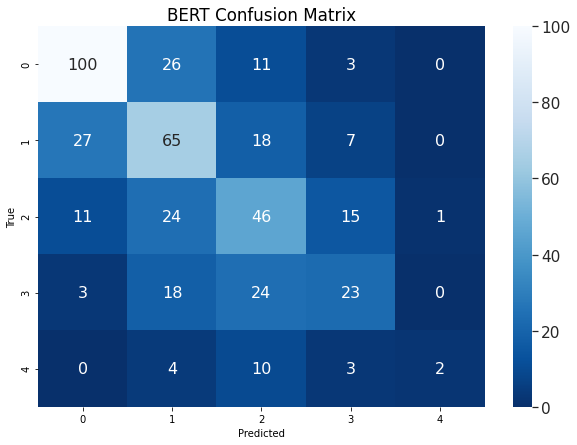

In [67]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

labels = [0,1,2,3,4]
cm = confusion_matrix(np.array(test_dataset['label']), np.argmax(predictions.predictions, axis=1), labels = labels)

fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)
sn.set(font_scale=1.4) # for label size
plt.title('BERT Confusion Matrix')
sn.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g', cmap='Blues_r', ax = ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

In [49]:
df = pd.DataFrame(np.column_stack([
                      np.array(test_dataset['text']), 
                      np.array(test_dataset['label']), 
                      np.argmax(predictions.predictions, axis=1),
                      np.array(torch.count_nonzero(test_dataset['input_ids'], dim=1))
                    ]),
                  columns=['text', 'actual', 'predicted', 'token_length']
                  )
df['is_correct'] = df['actual'] == df['predicted']
df['token_length'] = df['token_length'].astype('int')

### Average number of tokens for correct classifications vs misclassifications:

In [58]:
df.groupby('is_correct').mean().reset_index()

,is_correct,token_length
0,False,194.653659
1,True,164.737288


### Sarcasm misclassification:

In [59]:
df[df['text'] == "World class uni with the bus service of a 3rd world country"]

,text,actual,predicted,token_length,is_correct
266,World class uni with the bus service of a 3rd ...,1,0,15,False


### Long posts - transition of emotional state from annoyance (2) to anger (4):

In [60]:
confused_4_to_2 = list(df[(df['predicted'] == '2') & (df['actual'] == '4')]['text'])

In [66]:
confused_4_to_2[5]

'I have an increasingly tense relationship with my mom Not to say whos right or wrong but just that both of us are really on different frequencies she cant understand my needs nor can I understand hers And when I do things that are different from what she thinks just attending to my own matters nothing to do with her at all she immediately starts to get frustrated and hides me for not doing it the simpler way which isnt necessarily the case because I have my own considerations Ive been trying badly to hold in my rage for many years now but am reaching my capacity I want to leave this house really badly and want to keep my distance from her but I dont have the means to do significant other Once I get the opportunity too I will make sure I do I am significant other incredibly angry with our situation'

# 3c. Extracting Contextual Embeddings of Go-Emotions Pre-Trained & NUSWhispers Fine-Tuned BERT


In [ ]:
save_directory = '/content/drive/MyDrive/ge_nw_bert/'
tokenizer = BertTokenizerFast.from_pretrained(save_directory)
model = BertForSequenceClassification.from_pretrained(save_directory,
                                                      output_hidden_states=True)

In [ ]:
train_dataset = load_nuswhispers_datasets(model_name)

Here we are extracting the embeddings produced by the final hidden layer (before the classification head), where we simply used the embeddings of each post's [CLS] token (a special token appended to the start of every text by the BERT tokenizer). There are also other strategies, e.g. average or max pooling all token's embeddings, taking the 2nd to last hidden layer's embeddings instead of the last, or even pooling the last 4 hidden layers.

In [ ]:
def generate_embedding(x):
  inputs = {
    "input_ids": torch.tensor(x['input_ids']).unsqueeze(0),
    "attention_mask": torch.tensor(x['attention_mask']).unsqueeze(0),
  }

  with torch.no_grad():
    output = model(**inputs)
    logits = output[0]
    hidden_states = output[1]
    last_hidden_state = hidden_states[1] # layer right before the classification head
  # Get [CLS] embedding
  features = last_hidden_state[:,0,:].numpy()

  return features

df = train_dataset.to_pandas()
embeddings = df.apply(generate_embedding, axis=1)

In [ ]:
# sanity check
# b = generate_embedding(df.iloc[0])
# c = generate_embedding(df.iloc[100])
# c[1][1][:,0,:] - b[1][1][:,0,:]

In [ ]:
embeddings

In [ ]:
embeddings.to_csv('drive/MyDrive/ge_nw_bert_embeddings.csv')

# Extending BERT with Other Numerical Features

In [ ]:
train_dataset, val_dataset, test_dataset = load_nuswhispers_datasets(model_name)

In [ ]:
model = pt_bert_extended(model_name, num_labels, True)

In [ ]:
# training_args = TrainingArguments(
#     output_dir='./nuswhispersbert/results',          # output directory
#     learning_rate=2e-5,
#     num_train_epochs=4.0,            # total # of training epochs
#     per_device_train_batch_size=16,  # batch size per device during training
#     per_device_eval_batch_size=16,   # batch size for evaluation
#     warmup_ratio=0.1,                # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # strength of weight decay
#     logging_dir='./nuswhispersbert/logs',            # directory for storing logs
#     load_best_model_at_end=True,
#     metric_for_best_model='f1',
# )

# trainer = Trainer(
#     model=model,                         # the instantiated 🤗 Transformers model to be trained
#     args=training_args,                  # training arguments, defined above
#     train_dataset=train_dataset,         # training dataset
#     eval_dataset=val_dataset,            # evaluation dataset
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )
class CustomTrainer(Trainer):
  def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
    
    pass


In [ ]:
trainer.train()

In [ ]:
# save model
save_directory = '/content/drive/MyDrive/nuswhispers_bert_extended/'
tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)